In [9]:
from google.colab import files
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc
)
from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:

# ===== Step 1: Load & Inspect Data =====
uploaded = files.upload()  # select your 'bill_authentication.csv'
df = pd.read_csv('bill_authentication.csv')

print("\n== Data Info ==")
print(df.info())
print("\n== Statistical Summary ==")
print(df.describe())
print("\n== Class Distribution ==")
print(df['Class'].value_counts(), "\n")

Saving bill_authentication.csv to bill_authentication (1).csv

== Data Info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variance  1372 non-null   float64
 1   Skewness  1372 non-null   float64
 2   Curtosis  1372 non-null   float64
 3   Entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None

== Statistical Summary ==
          Variance     Skewness     Curtosis      Entropy        Class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650  

In [11]:

# ===== Step 2: Preprocess =====
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [12]:

# ===== Step 3: Train Models =====
models = {
    "Logistic Regression":   LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors":   KNeighborsClassifier(),
    "Gaussian Naive Bayes":  GaussianNB(),
    "Random Forest":         RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

In [13]:
# ===== Step 4: Evaluate & Print Results =====
results = {}
print("\n== Model Performance ==")
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm     = confusion_matrix(y_test, y_pred)

    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    results[name] = acc

best = max(results, key=results.get)
print(f"\n>> Best performing model: {best} ({results[best]:.4f})")


== Model Performance ==

--- Logistic Regression ---
Accuracy: 0.9806
Confusion Matrix:
[[223   6]
 [  2 181]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9911    0.9738    0.9824       229
           1     0.9679    0.9891    0.9784       183

    accuracy                         0.9806       412
   macro avg     0.9795    0.9814    0.9804       412
weighted avg     0.9808    0.9806    0.9806       412


--- K-Nearest Neighbors ---
Accuracy: 1.0000
Confusion Matrix:
[[229   0]
 [  0 183]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       229
           1     1.0000    1.0000    1.0000       183

    accuracy                         1.0000       412
   macro avg     1.0000    1.0000    1.0000       412
weighted avg     1.0000    1.0000    1.0000       412


--- Gaussian Naive Bayes ---
Accuracy: 0.8374
Confusion Matrix:
[[207  22]
 [ 45 138]]
Classificatio

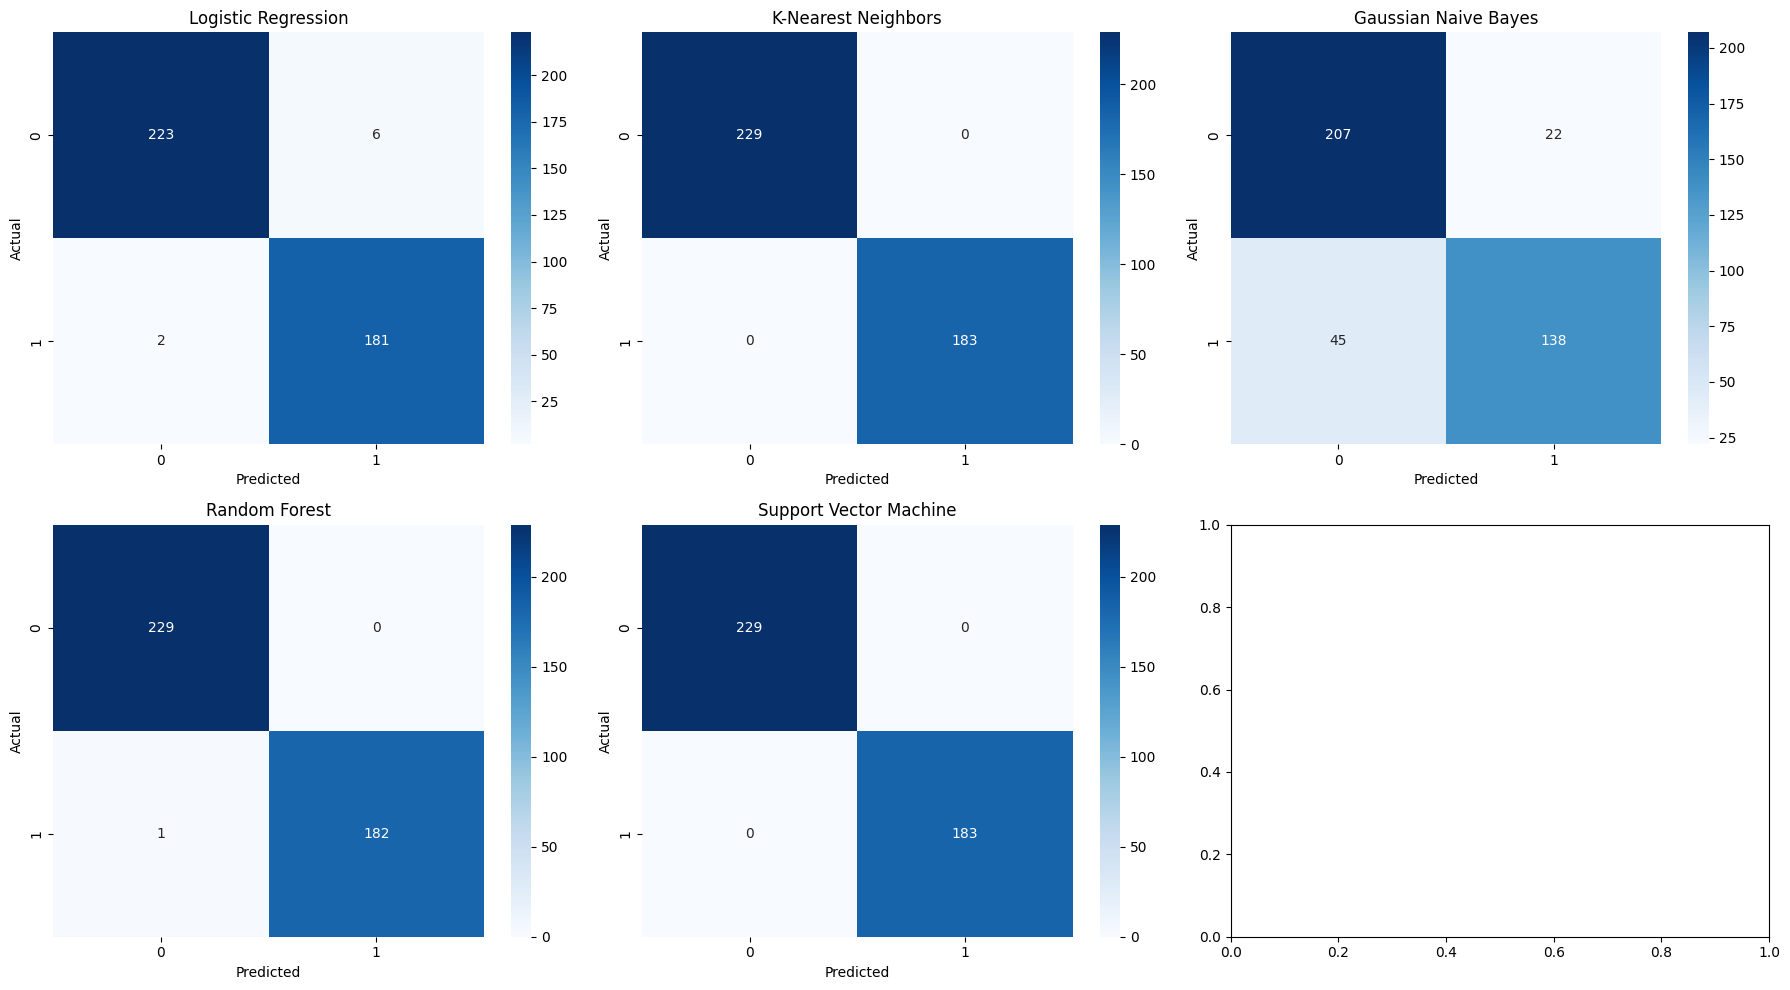

In [14]:
# ===== Step 5: Confusion Matrix Heatmaps =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test_scaled))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

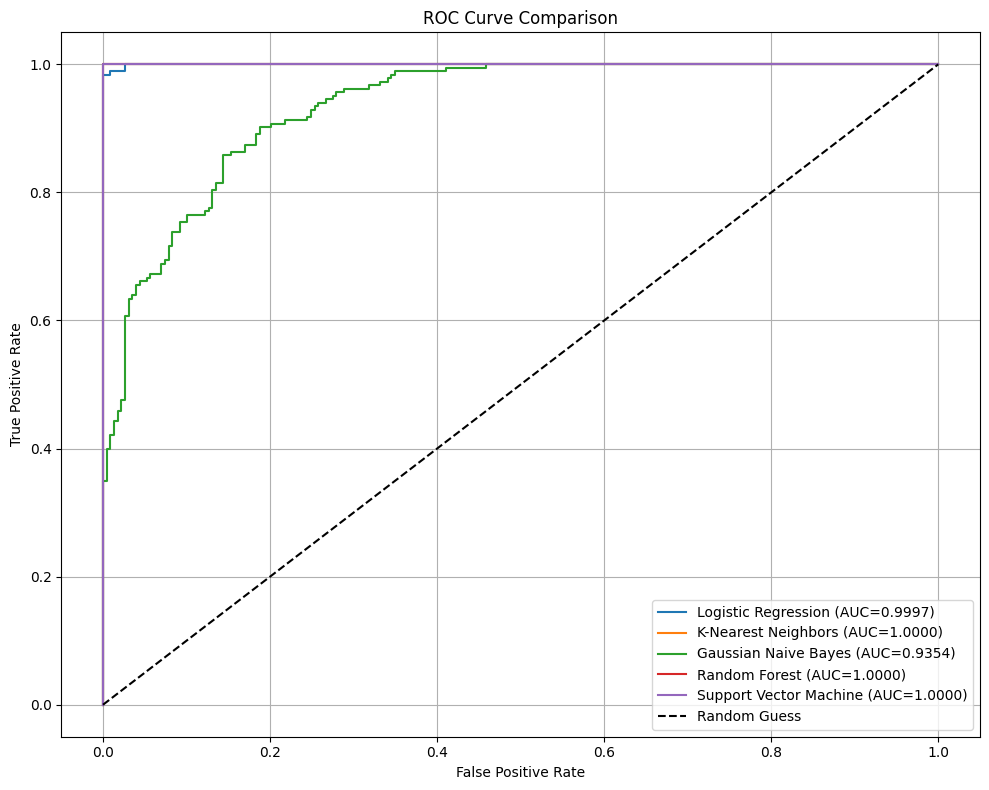

In [15]:
# ===== Step 6: ROC Curve Comparison =====
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        scores = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test_bin, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

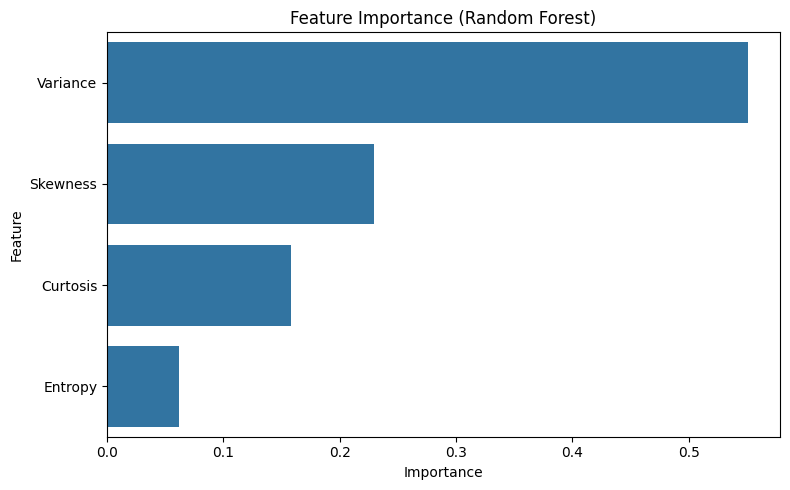

In [16]:
# ===== Step 7: Feature Importance (Random Forest) =====
rf = models["Random Forest"]
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()